<a href="https://colab.research.google.com/github/giacomoaccursi/Tirocinio/blob/main/train_with_angles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
rm -rf Tirocinio/

In [2]:
!git clone https://github.com/giacomoaccursi/Tirocinio.git

Cloning into 'Tirocinio'...
remote: Enumerating objects: 168731, done.
remote: Counting objects: 100% (12466/12466), done.
remote: Compressing objects: 100% (12460/12460), done.
remote: Total 168731 (delta 8), reused 12463 (delta 6), pack-reused 156265
Receiving objects: 100% (168731/168731), 902.67 MiB | 34.18 MiB/s, done.
Resolving deltas: 100% (3716/3716), done.
Checking out files: 100% (78992/78992), done.


In [3]:
import json
import numpy as np
import pandas as pd
import math

In [4]:
from os import listdir
from os.path import isfile, join
#lista tutti i file dato un percorso
def list_all_files(input_path):
  files = [join(input_path, f) for f in listdir(input_path) if isfile(join(input_path, f))]
  return list(zip(files, listdir(input_path)))

def list_all_in_dir(input_path):
  files = [join(input_path, f) for f in listdir(input_path)]
  return files

In [5]:
def angle_between_2_vectors(a, b, c):
  a = np.array(a)
  b = np.array(b)
  c = np.array(c)

  ba = a - b
  bc = c - b

  norm_ba = np.linalg.norm(ba)
  norm_bc = np.linalg.norm(bc)

  if (norm_ba == 0 or norm_bc == 0): 
    return 0
  
  cosine_angle = np.dot(ba, bc) / ((norm_ba) * (norm_bc))
  angle = np.arccos(cosine_angle)

  return np.degrees(angle)

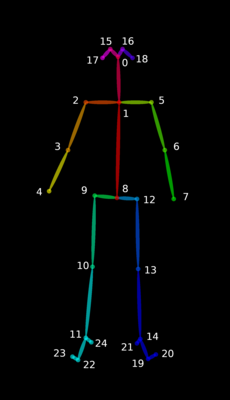

In [32]:
def calculate_angles(data):
  angle_vec = []

  angles = [
  (0, 1, 8),
  (0, 1, 2), 
  (0, 1, 5),
  (1, 2, 3),
  (2, 3, 4),
  (1, 5, 6),
  (5, 6, 7), 
  (1, 12, 13), 
  (1, 9, 10), 
  (8, 9, 10), 
  (8, 12, 13), 
  (9, 10, 11), 
  (12, 13, 14), 
  (10, 11, 22), 
  (13, 14, 19),
  (0, 8, 11), 
  (0, 8, 14), 
  (1, 8, 11), 
  (1, 8, 14)
]
  for elem in angles:
    coord = tuple(data[i] for i in elem)
    angle = angle_between_2_vectors(*coord)
    angle_vec.append(angle)
  return angle_vec

In [33]:
#estrae i dati dal file json
def extract_json_detection(file):
  with open(file, 'r') as f:
    data = json.load(f)
    data = data["people"][0]["pose_keypoints_2d"]
  return data

In [34]:
def coordinates_from_data(data): 
  del data[2:75:3] 
  new_data = [ [data[i], data[i+1]] for i in range(0, len(data), 2)]
  return new_data

ad ogni frame ho le coordinate. 
creo delle triple di coordinate e poi le passo alla funzione angle_between_points()


In [35]:
video_data = []
video_processed = sorted(list_all_in_dir("/content/Tirocinio/video_train_output"))
for output in video_processed:
  print(output)
  files = sorted(list_all_files(output))
  angles = []
  for file in files[:100]: 
    data = coordinates_from_data(extract_json_detection(file[0]))
    angles.append(calculate_angles(data))
  video_data.append(angles)

/content/Tirocinio/video_train_output/video_001_0
/content/Tirocinio/video_train_output/video_002_0
/content/Tirocinio/video_train_output/video_003_0
/content/Tirocinio/video_train_output/video_004_0
/content/Tirocinio/video_train_output/video_005_0
/content/Tirocinio/video_train_output/video_006_0
/content/Tirocinio/video_train_output/video_007_0
/content/Tirocinio/video_train_output/video_008_0
/content/Tirocinio/video_train_output/video_009_0
/content/Tirocinio/video_train_output/video_010_0
/content/Tirocinio/video_train_output/video_011_0
/content/Tirocinio/video_train_output/video_012_0
/content/Tirocinio/video_train_output/video_013_0
/content/Tirocinio/video_train_output/video_014_0
/content/Tirocinio/video_train_output/video_015_0
/content/Tirocinio/video_train_output/video_016_0
/content/Tirocinio/video_train_output/video_017_0
/content/Tirocinio/video_train_output/video_018_0
/content/Tirocinio/video_train_output/video_019_0
/content/Tirocinio/video_train_output/video_020_0


In [36]:
labels = []
for output in video_processed: 
  labels.append(output.split("_")[-1])
 

In [37]:
labels = np.array(labels)

In [38]:
video_data = np.array(video_data)

In [39]:
video_data.shape

(322, 100, 19)

In [40]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels)

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
video_data = scaler.fit_transform(video_data.reshape(-1, video_data.shape[-1])).reshape(video_data.shape)


In [42]:
from sklearn.model_selection import train_test_split

(X_train, X_val, y_train, y_val) = train_test_split(video_data, labels,
	test_size=0.25,stratify=labels, random_state=42)

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Dropout
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
  Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),                   
  Dense(256 , activation="relu"), 
  Dropout(0.5),
  Dense(128, activation="relu"),
  Dropout(0.5),
  Dense(64, activation="relu"),
  Dense(y_train.shape[1], activation = "softmax")
])

In [82]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [83]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/20
4/4 [==============================] - 1s 62ms/step - loss: 1.2419 - accuracy: 0.4481 - val_loss: 0.4828 - val_accuracy: 0.8765
Epoch 2/20
4/4 [==============================] - 0s 13ms/step - loss: 0.6886 - accuracy: 0.6805 - val_loss: 0.3441 - val_accuracy: 0.8889
Epoch 3/20
4/4 [==============================] - 0s 12ms/step - loss: 0.4373 - accuracy: 0.8133 - val_loss: 0.2821 - val_accuracy: 0.9136
Epoch 4/20
4/4 [==============================] - 0s 12ms/step - loss: 0.3349 - accuracy: 0.8797 - val_loss: 0.2437 - val_accuracy: 0.9259
Epoch 5/20
4/4 [==============================] - 0s 13ms/step - loss: 0.3142 - accuracy: 0.8797 - val_loss: 0.2128 - val_accuracy: 0.9383
Epoch 6/20
4/4 [==============================] - 0s 14ms/step - loss: 0.2560 - accuracy: 0.8963 - val_loss: 0.1893 - val_accuracy: 0.9383
Epoch 7/20
4/4 [==============================] - 0s 14ms/step - loss: 0.2500 - accuracy: 0.9087 - val_loss: 0.1790 - val_accuracy: 0.9506
Epoch 8/20
4/4 [===========

In [84]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 1900)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)               486656    
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_51 (Dense)             (None, 3)               

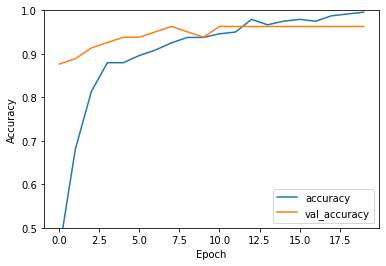

In [85]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

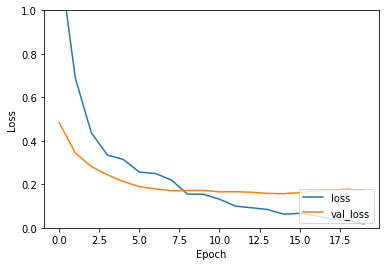

In [87]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [88]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

y_pred_val = model.predict(X_val)
y_pred_val = [np.argmax(i) for i in y_pred_val]
y_real_val = [np.argmax(i) for i in y_val]
confusion_matrix(y_real_val, y_pred_val)

array([[27,  0,  0],
       [ 0, 26,  2],
       [ 0,  1, 25]])

In [89]:
y_pred_train = model.predict(X_train)
y_pred_train = [np.argmax(i) for i in y_pred_train]
y_real_train = [np.argmax(i) for i in y_train]
confusion_matrix(y_real_train, y_pred_train)

array([[79,  0,  0],
       [ 0, 85,  0],
       [ 0,  0, 77]])

In [90]:
print(classification_report(y_real_val, y_pred_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.96      0.93      0.95        28
           2       0.93      0.96      0.94        26

    accuracy                           0.96        81
   macro avg       0.96      0.96      0.96        81
weighted avg       0.96      0.96      0.96        81



In [91]:
def accuracy_interval(f):
  N = len(y_val)
  n_min = f + ( 1.96**2/(2*N) - 1.96 * np.sqrt( (f/N) - (f**2/N) + (1.96**2/(4*N**2) ) ) ) 
  n_max = f + ( 1.96**2/(2*N) + 1.96 * np.sqrt( (f/N) - (f**2/N) + (1.96**2/(4*N**2) ) ) ) 
  d = 1 + (1.96**2 / N)
  e_min = n_min / d
  e_max = n_max / d
  return np.round(e_min,4), np.round(e_max,4)

In [92]:
accuracy_interval(f1_score(y_real_val, y_pred_val,average="macro"))

(0.8967, 0.9873)

In [ ]:
from keras.models import load_model
model.save('modello.h5')